# What European Soccer Team Attributes Lead To More Wins?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I will be analyzing a dataset derived from the Kaggle European Soccer Database. The dataset ecompasses match, team,country and league data. I will be exploring the team attributes associated with winning teams.


The Dataset was derived usng the SQL query below:

~~~~sql
CREATE TABLE team_match_data AS 
WITH team_data AS (
SELECT * 
FROM Team_Attributes ta
JOIN Team t
ON ta.team_api_id = t.team_api_id),


	teamdate_data AS (
SELECT *,
lead(team_api_id) OVER (PARTITION BY team_api_id ORDER BY "date") AS lead_team_api_id,
lead("date",1,"2016-05-25 00:00:00") OVER (PARTITION BY team_api_id ORDER BY "date") AS end_date
FROM team_data)


SELECT m.match_api_id, 
m."date" match_dt,
m.country_id,
c.name country_name,
m.league_id,
l.name league_name,
m.season,
m.home_team_api_id,
m.away_team_api_id,
td.team_api_id,
td.team_long_name,
td.team_short_name,
m.home_team_goal,
m.away_team_goal,
td."date" t_attr_start_dt,
td.end_date t_attr_end_dt,
td.buildUpPlaySpeed bu_play_speed,
td.buildUpPlaySpeedClass bu_play_speed_class,
td.buildUpPlayDribbling bu_play_dribbling,
td.buildUpPlayDribblingClass bu_play_dribbling_class,
td.buildUpPlayPassing bu_play_passing,
td.buildUpPlayPassingClass bu_play_passing_class,
td.buildUpPlayPositioningClass bu_play_positioning_class,
td.chanceCreationPassing cc_passing,
td.chanceCreationPassingClass cc_passing_class,
td.chanceCreationCrossing cc_crossing,
td.chanceCreationCrossingClass cc_crossing_class,
td.chanceCreationShooting cc_shooting,
td.chanceCreationShootingClass cc_shooting_class,
td.chanceCreationPositioningClass cc_positioning_class,
td.defencePressure defence_pressure,
td.defencePressureClass defence_pressure_class,
td.defenceAggression defence_aggression,
td.defenceAggressionClass defence_agression_class,
td.defenceTeamWidth defence_team_width,
td.defenceTeamWidthClass defence_team_width_class,
td.defenceDefenderLineClass defence_line_class
FROM Match m
JOIN teamdate_data td
ON td.team_api_id = m.home_team_api_id
OR td.team_api_id = m.away_team_api_id
JOIN League l
ON l.id = m.league_id
JOIN Country c
ON c.id = m.country_id
WHERE m."date"  BETWEEN td."date" AND td.end_date
ORDER BY td.team_api_id, td.end_date DESC;
~~~~

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [116]:
df = pd.read_csv('team_match_data.csv')
df.head()

,match_api_id,match_dt,country_id,country_name,league_id,league_name,season,home_team_api_id,away_team_api_id,team_api_id,...,cc_shooting,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class
0,1994692,2015-09-26 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,2186,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1,1994701,2015-10-02 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,1601,8023,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
2,1994710,2015-10-17 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,2182,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,1994716,2015-10-23 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,1601,8025,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,1994723,2015-10-30 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,10265,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


In [117]:
df.shape

(39882, 37)

In [118]:
df.describe()

,match_api_id,country_id,league_id,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,3.988200e+04,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,11749.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000
mean,1.360436e+06,11763.067148,11763.067148,9956.776992,9954.216087,9665.847425,1.554787,1.173888,52.412818,49.088433,47.927210,52.411664,54.034627,54.270473,46.466978,49.474625,52.337596
std,4.222426e+05,7520.607243,7520.607243,13767.842735,13738.480474,11287.448154,1.306828,1.147342,11.930429,9.800439,11.081696,10.400321,11.184020,10.440281,10.215524,9.871917,9.435304
min,6.541530e+05,1.000000,1.000000,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000
25%,1.025090e+06,4769.000000,4769.000000,8472.000000,8472.000000,8481.000000,1.000000,0.000000,45.000000,42.000000,39.000000,47.000000,48.000000,49.000000,39.000000,44.000000,48.000000
50%,1.260174e+06,10257.000000,10257.000000,8697.000000,8697.000000,8721.000000,1.000000,1.000000,52.000000,49.000000,49.000000,52.000000,53.000000,54.000000,46.000000,48.000000,52.000000
75%,1.724266e+06,17642.000000,17642.000000,9925.000000,9925.000000,9925.000000,2.000000,2.000000,62.000000,55.000000,55.000000,60.000000,63.000000,62.000000,53.000000,56.000000,59.000000
max,2.216672e+06,24558.000000,24558.000000,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 37 columns):
match_api_id                 39882 non-null int64
match_dt                     39882 non-null object
country_id                   39882 non-null int64
country_name                 39882 non-null object
league_id                    39882 non-null int64
league_name                  39882 non-null object
season                       39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          3988

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

In [120]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df.drop(['match_api_id','country_id','league_id','country_name','league_name', 'season'], axis=1, inplace = True)

In [121]:
df.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class
0,2015-09-26 00:00:00,2186,1601,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1,2015-10-02 00:00:00,1601,8023,1601,Ruch Chorzów,CHO,0,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
2,2015-10-17 00:00:00,2182,1601,1601,Ruch Chorzów,CHO,2,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,2015-10-30 00:00:00,10265,1601,1601,Ruch Chorzów,CHO,0,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 31 columns):
match_dt                     39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          39882 non-null object
bu_play_dribbling            11749 non-null float64
bu_play_dribbling_class      39882 non-null object
bu_play_passing              39882 non-null int64
bu_play_passing_class        39882 non-null object
bu_play_positioning_class    39882 non-null object
cc_passing                   3

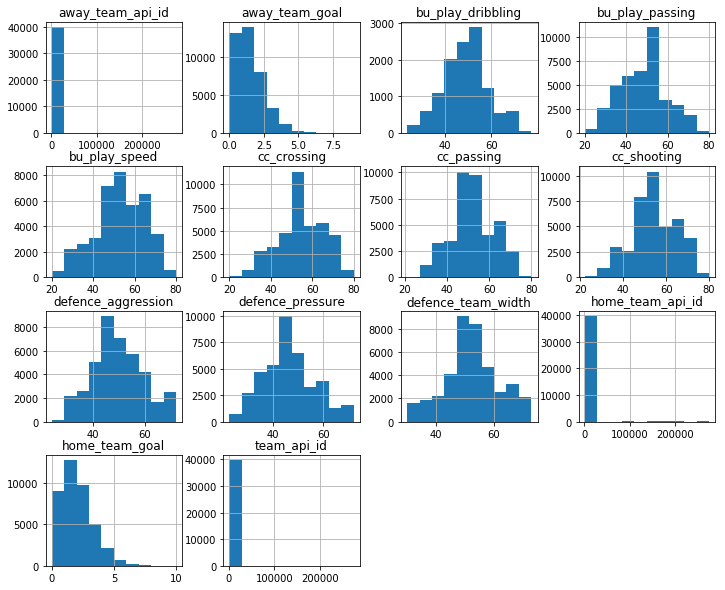

In [123]:
df.hist(figsize=(12,10));

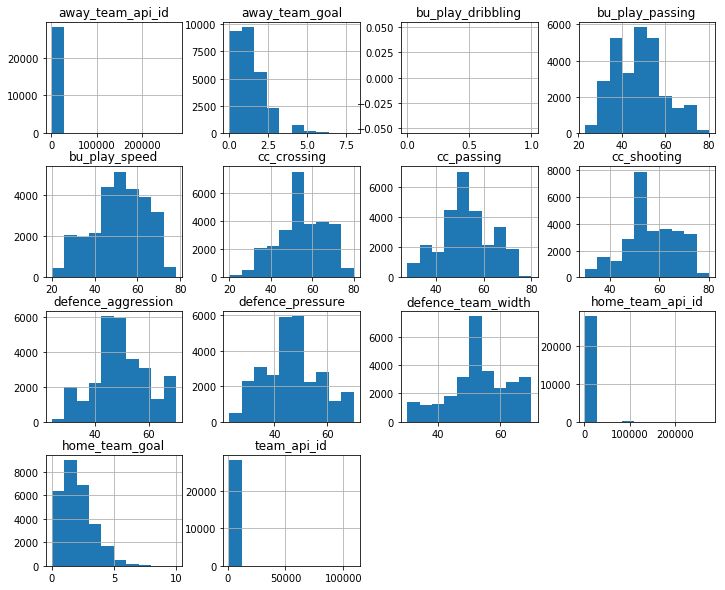

In [124]:
df[df.bu_play_dribbling.isnull()].hist(figsize=(12,10));

In [125]:
# Find the bu_play_dribbling clases
df.bu_play_dribbling_class.unique()

array(['Normal', 'Little', 'Lots'], dtype=object)

In [136]:
df[df.bu_play_dribbling.isnull()]['bu_play_dribbling_class'].unique()

array(['Little'], dtype=object)

All of the null values from the bu_play_dribbling column belong to the bu_play_dribbling_class "Little". We need to fill those null values with the mean of the "Little" bu_play_dribbling columns

In [137]:
# Normal Build Up Dribblig Class df
df_normal_dribbling_class = df.query('bu_play_dribbling_class == "Normal"')

In [138]:
# Range for Normal Build Up Dribblig
(df_normal_dribbling_class.bu_play_dribbling.min(), df_normal_dribbling_class.bu_play_dribbling.max())

(34.0, 66.0)

In [139]:
# Lots Build Up Dribblig Class df
df_lots_dribbling_class = df.query('bu_play_dribbling_class == "Lots"')

In [140]:
# Range for Lots Build Up Dribblig
(df_lots_dribbling_class.bu_play_dribbling.min(),df_lots_dribbling_class.bu_play_dribbling.max())

(67.0, 77.0)

In [141]:
# Little Build Up Dribblig Class df
df_little_dribbling_class = df.query('bu_play_dribbling_class == "Little"')

In [142]:
# Range for Little Build Up Dribblig
(df_little_dribbling_class.bu_play_dribbling.min(),df_little_dribbling_class.bu_play_dribbling.max())

(24.0, 33.0)

In [143]:
# Find the mean of the Little Build Up Dribbling class df
df_little_dribbling_class['bu_play_dribbling'].mean()

30.44859813084112

In [144]:
# Fill nan values with the mean of the litle dribbling class since they were all inthe little dribblng class
df['bu_play_dribbling'].fillna(df_little_dribbling_class['bu_play_dribbling'].mean(), inplace=True)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 31 columns):
match_dt                     39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          39882 non-null object
bu_play_dribbling            39882 non-null float64
bu_play_dribbling_class      39882 non-null object
bu_play_passing              39882 non-null int64
bu_play_passing_class        39882 non-null object
bu_play_positioning_class    39882 non-null object
cc_passing                   3

In [146]:
df.duplicated().sum()

0

In [147]:
df.shape

(39882, 31)

In [148]:
df.describe()

,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000
mean,9956.776992,9954.216087,9665.847425,1.554787,1.173888,52.412818,35.939783,47.927210,52.411664,54.034627,54.270473,46.466978,49.474625,52.337596
std,13767.842735,13738.480474,11287.448154,1.306828,1.147342,11.930429,10.024826,11.081696,10.400321,11.184020,10.440281,10.215524,9.871917,9.435304
min,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000
25%,8472.000000,8472.000000,8481.000000,1.000000,0.000000,45.000000,30.448598,39.000000,47.000000,48.000000,49.000000,39.000000,44.000000,48.000000
50%,8697.000000,8697.000000,8721.000000,1.000000,1.000000,52.000000,30.448598,49.000000,52.000000,53.000000,54.000000,46.000000,48.000000,52.000000
75%,9925.000000,9925.000000,9925.000000,2.000000,2.000000,62.000000,38.000000,55.000000,60.000000,63.000000,62.000000,53.000000,56.000000,59.000000
max,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Question 1 : Which Team won the most matches?

In [149]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# Get matches that did not result in a Tied Match
df_match_no_draw = df.query('home_team_goal != away_team_goal')

In [150]:
df_match_no_draw.shape

(29758, 31)

In [151]:
df_match_no_draw.describe()

,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.00000,29758.000000
mean,9961.051415,9899.828685,9626.486491,1.743733,1.233248,52.347402,35.914585,47.896129,52.440117,54.045433,54.308354,46.573190,49.51361,52.355400
std,13757.721340,13420.665962,10930.258097,1.381442,1.229052,11.931015,9.982912,11.071162,10.413259,11.176362,10.476461,10.228084,9.87437,9.414251
min,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.00000,30.000000
25%,8481.000000,8472.000000,8483.000000,1.000000,0.000000,45.000000,30.448598,39.000000,47.000000,48.000000,49.000000,39.000000,44.00000,48.000000
50%,8697.000000,8697.000000,8721.000000,2.000000,1.000000,52.000000,30.448598,49.000000,52.000000,53.000000,54.000000,46.000000,48.00000,52.000000
75%,9925.000000,9925.000000,9925.000000,3.000000,2.000000,62.000000,38.000000,55.000000,60.000000,63.000000,63.000000,53.000000,56.00000,59.000000
max,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.00000,73.000000


In [152]:
#Create a column to identify the winning team
df_match_no_draw['win_team_id'] = np.where(df_match_no_draw['home_team_goal'] > df_match_no_draw['away_team_goal'], df_match_no_draw['home_team_api_id'], df_match_no_draw['away_team_api_id'])

/home/kimberley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [153]:
df_match_no_draw.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id
0,2015-09-26 00:00:00,2186,1601,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,2186
1,2015-10-02 00:00:00,1601,8023,1601,Ruch Chorzów,CHO,0,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,8023
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
5,2015-11-07 00:00:00,1601,8030,1601,Ruch Chorzów,CHO,3,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
6,2015-11-21 00:00:00,8019,1601,1601,Ruch Chorzów,CHO,0,3,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601


In [154]:
# Filter the teams attributes for the team that won
df_win_team = df_match_no_draw.query('team_api_id == win_team_id')

In [155]:
df_win_team.shape

(15010, 32)

In [156]:
df_win_team.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
5,2015-11-07 00:00:00,1601,8030,1601,Ruch Chorzów,CHO,3,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
6,2015-11-21 00:00:00,8019,1601,1601,Ruch Chorzów,CHO,0,3,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
8,2015-12-01 00:00:00,1601,8245,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
11,2015-12-19 00:00:00,177361,1601,1601,Ruch Chorzów,CHO,0,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601


In [157]:
# Count the number of wins for each team and sort in decending order
df_num_wins=df_win_team.groupby(['team_long_name'])['win_team_id'].count().sort_values(ascending=False)

In [158]:
# Top Ten Soccer Teams
top_10 = df_num_wins.head(10)

In [159]:
top_10

team_long_name
FC Barcelona           189
Real Madrid CF         185
Celtic                 180
FC Bayern Munich       159
Juventus               156
SL Benfica             153
FC Porto               149
Manchester City        148
Paris Saint-Germain    147
Manchester United      146
Name: win_team_id, dtype: int64

In [160]:
df_num_wins.idxmax()

'FC Barcelona'

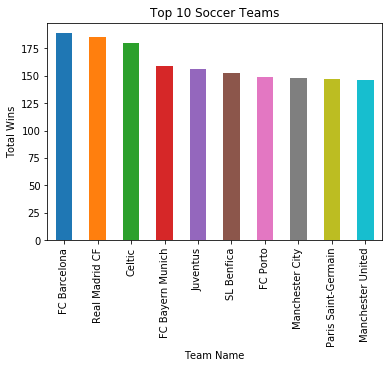

In [161]:
# Plot a bar chart showing the Top 10 Soccer Teams
top_10.plot(kind='bar');
plt.title('Top 10 Soccer Teams')
plt.xlabel('Team Name')
plt.ylabel('Total Wins');

### Question 2  : What team attributes contribute to the most wins for FC Barcelona?

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])